In [2]:
import pystan
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#We begin with creating stan models.

In [3]:
student = """
data {
    real nu;
    real mu;
    real sigma;
}
generated quantities {
    real y = student_t_rng(nu, mu, sigma);
}
"""
modelStudent = pystan.StanModel(model_code = student)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9707cb62e2bb926031c82976b1af43eb NOW.


In [4]:
normal = """
data {
    real mu;
    real sigma;
}
generated quantities {
    real y = normal_rng(mu, sigma);
}
"""
modelNormal = pystan.StanModel(model_code = normal)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b4786782e07a1755e8a975356770bde8 NOW.


In [9]:
#We do the sampling to get five Student distributions with different numbers of degrees of freedom as well as normal distr.
dataNormal = {'mu': 0, 'sigma': 1}
dataStudentList = []
sim_pcc_student_list = []
for i in range(1, 6):
    dataStudentList.append({'nu': i, 'mu': 0, 'sigma': 1})
for data in dataStudentList:
    sim_pcc_student_list.append(modelStudent.sampling(data = data, algorithm = 'Fixed_param', iter = 100))
sim_pcc_normal = modelNormal.sampling(data = dataNormal, algorithm = 'Fixed_param', iter = 100)

In [10]:
frames = []
for sampling in sim_pcc_student_list:
    frames.append(pd.DataFrame(sampling.extract()))
for i in range(len(frames)):
    frames[i].columns = ['nu = {}'.format(i + 1), 'lp__']
frameNormal = pd.DataFrame(sim_pcc_normal.extract())
frameNormal.columns = ['normal', 'lp__']

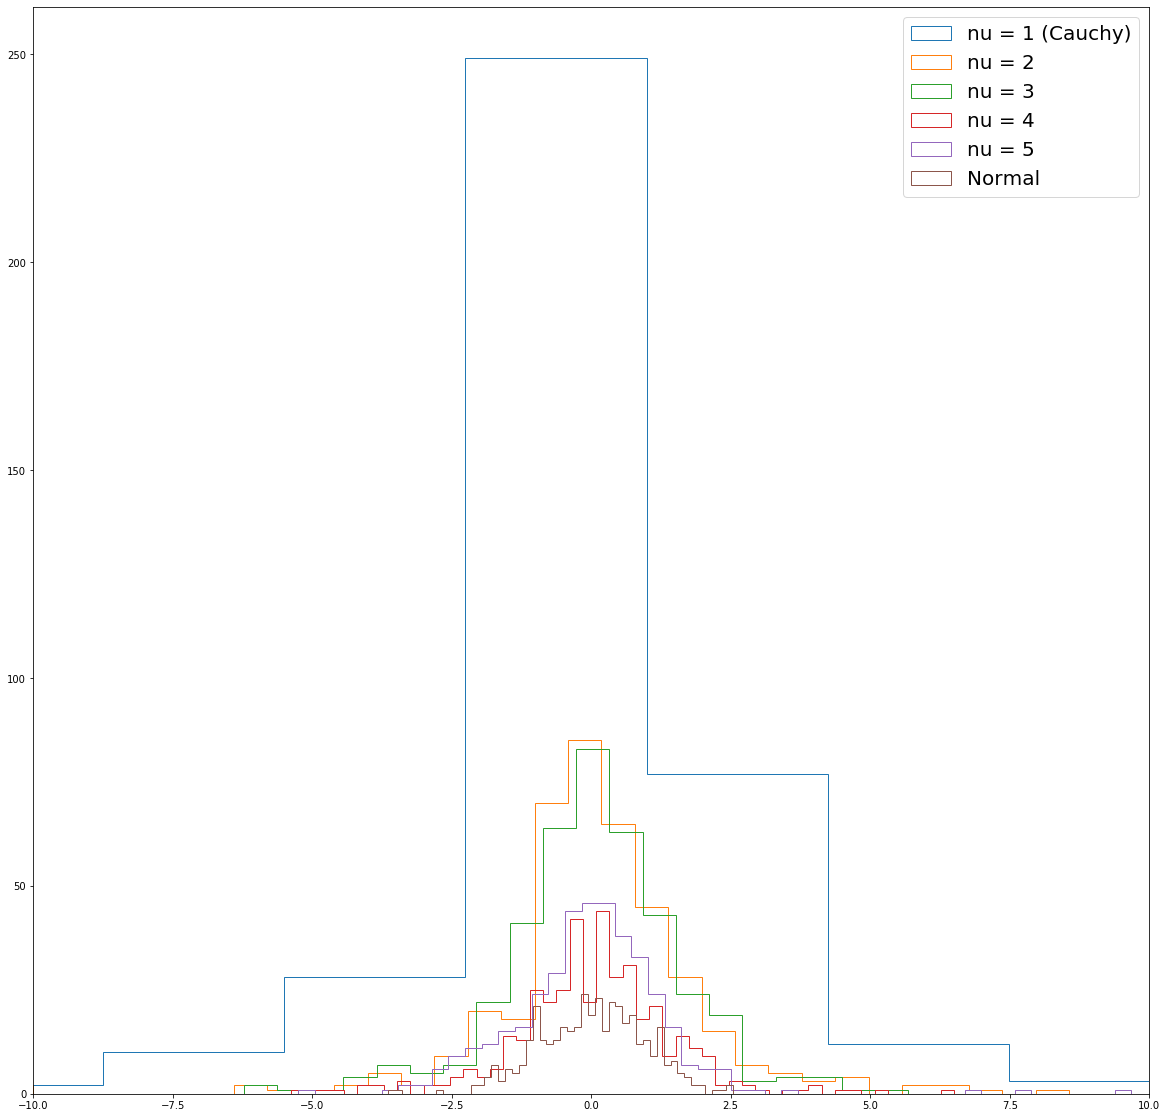

In [12]:
#We plot the histograms for all distributions.
plt.figure(figsize = (20, 20))
plt.xlim([-10, 10])
for i in range(5):
    plt.hist(frames[i]['nu = {}'.format(i + 1)], bins = 50, histtype = 'step')
plt.hist(frameNormal['normal'], bins = 50, histtype = 'step')
plt.legend(['nu = 1 (Cauchy)', 'nu = 2', 'nu = 3', 'nu = 4', 'nu = 5', 'Normal'], prop = {'size': 20})
plt.show()

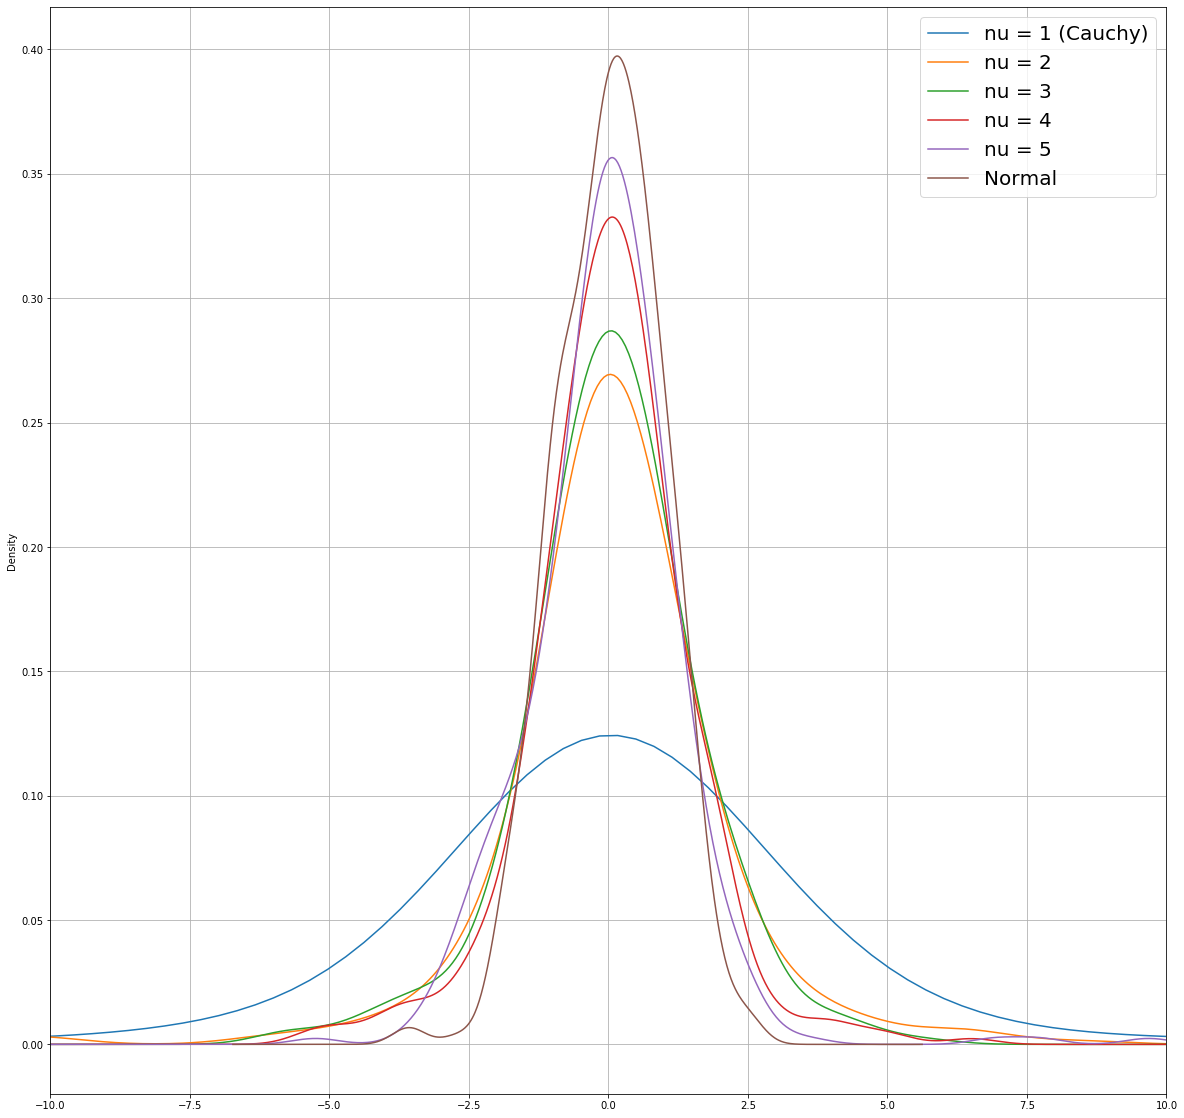

In [13]:
#Histograms are not quite legible, so we also plot kernel density estimations.
fig = plt.figure(figsize = (20, 20))
plt.xlim([-10, 10])
for i in range(5):
    frames[i]['nu = {}'.format(i + 1)].plot.kde()
frameNormal['normal'].plot.kde()
plt.legend(['nu = 1 (Cauchy)','nu = 2', 'nu = 3', 'nu = 4', 'nu = 5', 'Normal'], prop = {'size': 20})
plt.grid()
plt.show()

In [14]:
#We clearly see that the larger number of degrees of freedom, the closer distribution gets to the normal one.
#Now we check how number of samples influences mean and variance of the distribution (parameters: nu = 3, mu = 0, sigma = 1).
sampleNumbers = [10, 20, 50, 100, 1000, 10000]
frames = []
sim_pcc_student_list = []
studentData = {'nu': 3, 'mu': 0, 'sigma': 1}
for sampleNumber in sampleNumbers:
    sim_pcc_student_list.append(modelStudent.sampling(data = studentData, algorithm = 'Fixed_param', iter = sampleNumber))
for sim_pcc in sim_pcc_student_list:
    frames.append(pd.DataFrame(sim_pcc.extract()))

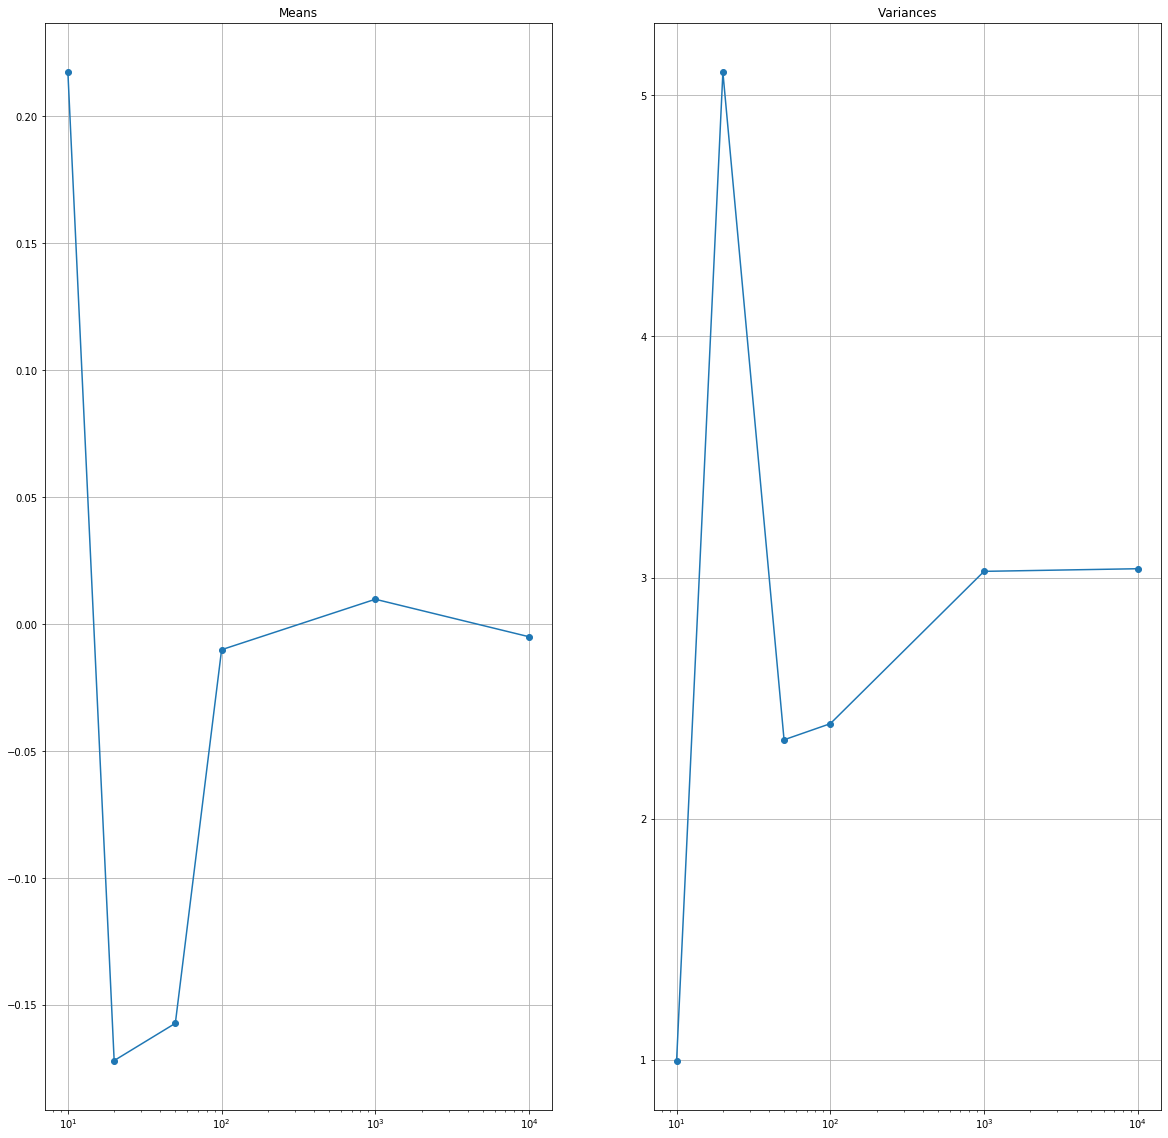

In [20]:
means = []
variances = []
for frame in frames:
    means.append(frame.iloc[:, 0].mean())
    variances.append(frame.iloc[:, 0].var())
plt.figure(figsize = [20, 20])
plt.subplot(1, 2, 1).set_title('Means')
plt.plot(sampleNumbers, means, 'o-')
plt.xscale('log')
plt.grid()
plt.subplot(1, 2, 2).set_title('Variances')
plt.plot(sampleNumbers, variances, 'o-')
plt.xscale('log')
plt.grid()
plt.show()

In [ ]:
#As we can see, with the number of samples increasing, mean approaches 0 and variance approaches 3, which are correct values.